In [1]:
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Project
# Copyright: Zhaoshuo Li, Ding Hao, Mingyi Zheng
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
import torchvision.transforms.functional as TF

from  PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorboardX import SummaryWriter

import transforms
from dataset import *
from visualization import *
from label_conversion import *
from dice_loss import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


# Seed pytorch and numpy and random

In [3]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

## Hyperparameters

In [4]:
train_batch_size = 10
validation_batch_size=10
learning_rate = 0.001
num_epochs = 70

## Network

In [ ]:
# define helper functions to add conv
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def add_merge_stage(ch_coarse, ch_fine, in_coarse, in_fine, upsample):
  conv = nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  torch.cat(conv, in_fine)

  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  )
  upsample(in_coarse)

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )


In [ ]:
# define unet model
num_class = 12
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    ## weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

    ## Design your last layer & activations
    self.outconv = nn.Conv2d(32,num_class,1)
    
  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out = self.conv1m(conv2m_out_)

    ## Design your last layer & activations
    outconv_out = self.outconv(conv1m_out)    
    
#     print('dimension of x', x.shape)
#     print('dimension of conv1_out', conv1_out.shape)
#     print('dimension of conv2_out', conv2_out.shape)
#     print('dimension of conv3_out', conv3_out.shape)

#     print('dimension of conv4_out', conv4_out.shape)
#     print('dimension of conv4m_out_', conv4m_out_.shape)

#     print('dimension of conv3m_out', conv3m_out.shape)
#     print('dimension of conv3m_out_', conv3m_out_.shape)

#     print('dimension of conv2m_out', conv2m_out.shape)
#     print('dimension of conv2m_out_', conv2m_out_.shape)

#     print('dimension of conv1m_out', conv1m_out.shape)
#     print('dimension of outconv_out', outconv_out.shape)

    return outconv_out

In [ ]:
# initialize model
model = unet(useBN=True)
model.to(device)

unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

## Optimizer

In [ ]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## train and validation function

In [ ]:
def train():
    ########################### Training #####################################
    # Please design your own training section
    scheduler.step()
    model.train()  # Set model to training mode           

    running_loss = 0.0
    
    for i_batch, batch in enumerate(train_generator):
        # read img and label
        img = batch[0]
        label = batch[1]
        
#         # validate if images are parsed correctly
#         print(i_batch, img.shape, label.shape)
#         sample_img = img[0,:,:,:]
#         sample_label = label[0,:,:,:]
#         sample_colorlabel = train_dataset.label_converter.label2color(sample_label.permute(1,2,0))
#         imshow(sample_img.permute(1,2,0),denormalize=True)
#         imshow(sample_colorlabel)
#         break

        # transfer to GPU
        img, label = img.to(device), label.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backprop + optimize
        outputs = model(img)
        loss,_,_ = dice_loss(outputs,label.long().squeeze(1))
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * img.size(0)       
        
        
                
    train_loss = running_loss / len(train_dataset)
    print('Epoch Loss: {:.4f}'.format(train_loss))
    print('-' * 10)
    
    return train_loss
    
def validate():
    ########################### Validation #####################################
    model.eval()  # Set model to validation mode   
    validation_loss = 0.0
    tp = torch.zeros(num_class)
    fp = torch.zeros(num_class)
    fn = torch.zeros(num_class)
    
    for i_batch, batch in enumerate(validation_generator):
        # read img and label
        img = batch[0]
        label = batch[1]

#         # validate if images are parsed correctly
#         print(i_batch, img.shape, label.shape)
#         sample_img = img[0,:,:,:]
#         sample_label = label[0,:,:,:]
#         sample_colorlabel = train_dataset.label_converter.label2color(sample_label.permute(1,2,0))
#         imshow(sample_img.permute(1,2,0),denormalize=True)
#         imshow(sample_colorlabel)
#         break
        
        # transfer to GPU
        img, label = img.to(device), label.to(device)

        # forward
        outputs = model(img)
        # get loss
        loss, probas, true_1_hot = dice_loss(outputs,label.long().squeeze(1))

        # statistics
        validation_loss += loss.item() * img.size(0)        
        curr_tp, curr_fp, curr_fn = label_accuracy(probas.cpu(),true_1_hot.cpu())
        tp += curr_tp
        fp += curr_fp
        fn += curr_fn
            
    validation_loss = validation_loss / len(validation_dataset)
    print('Vaildation Loss: {:.4f}'.format(validation_loss))
    for i_class, (tp_val, fp_val, fn_val) in enumerate(zip(tp, fp, fn)):
        print ('{} Class, True Pos {}, False Pos {}, Flase Neg {}'.format(i_class, tp_val,fp_val,fn_val))
    print('-' * 10)
    
    return validation_loss, tp, fp, fn

# Baseline, without augmentation

In [ ]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

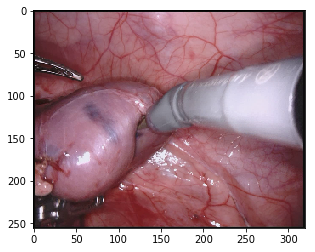

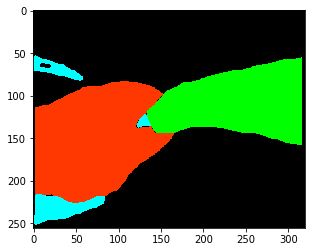

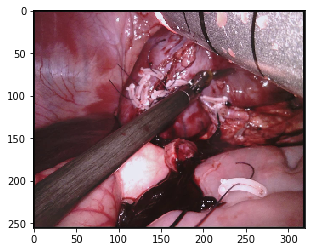

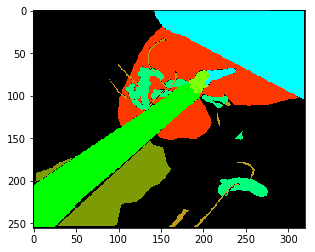

In [ ]:
# define transform
train_dataset=MICCAIDataset(data_type = "train", transform=None)
validation_dataset=MICCAIDataset(data_type = "validation", transform=None)
label_converter = LabelConverter()

# show one example
img,label = train_dataset.__getitem__(0)
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

# show one example
img,label = validation_dataset.__getitem__(0)
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

In [ ]:
# intialize the dataloader
train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

In [ ]:
print("Training Started!")

# Initialize the visualization environment
vis = Visualizations('Baseline')
writer = SummaryWriter()

best_acc = 0.0

for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    # train
    train_loss = train()

    # validate
    with torch.no_grad():
        validation_loss,tp, fp, fn = validate()
        epoch_acc = (2*tp + 1e-7)/ (2*tp+fp+fn+1e-7)
        epoch_acc = epoch_acc.mean()
    
        # loss
        writer.add_scalars('data/loss', {'Training Loss':train_loss,
                                         'Validation Loss':validation_loss}, epoch)
        
        # image
        sample = validation_dataset.__getitem__(random.randint(0,len(validation_dataset)-1))
        img = sample[0]*0.5+0.5
        tmp_img = sample[0].reshape(1,3,256,320)
        label = sample[1]
        pred = functional.softmax(model(tmp_img.cuda()), dim=1)
        pred_label = torch.max(pred,dim=1)[1]
        pred_label = pred_label.type(label.type())
        
        # to plot
        tp_img = np.array(img)
        tp_label = train_dataset.label_converter.label2color(label.permute(1,2,0)).transpose(2,0,1)
        tp_pred = train_dataset.label_converter.label2color(pred_label.permute(1,2,0)).transpose(2,0,1)

        vis.plot_image(tp_img,tp_label,tp_pred)
        
        writer.add_image('Input', tp_img, epoch)
        writer.add_image('Label', tp_label, epoch)
        writer.add_image('Prediction', tp_pred, epoch)
        
        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(vgg16.state_dict())

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

Training Started!
Exception in user code:
------------------------------------------------------------

EPOCH 1 of 70

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.8763
----------
Vaildation Loss: 0.8246
0 Class, True Pos 8305395.0, False Pos 5264231.0, Flase Neg 4800298.0
1 Class, True Pos 1450557.0, False Pos 1417758.0, Flase Neg 1088642.0
2 Class, True Pos 1108811.0, False Pos 2961107.0, Flase Neg 226619.0
3 Class, True Pos 11198.0, False Pos 289034.0, Flase Neg 552572.0
4 Class, True Pos 238027.0, False Pos 558397.0, Flase Neg 4699492.0
5 Class, True Pos 

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.7722
----------
Vaildation Loss: 0.7619
0 Class, True Pos 8348527.0, False Pos 4460293.0, Flase Neg 4757166.0
1 Class, True Pos 1626268.0, False Pos 1638055.0, Flase Neg 912931.0
2 Class, True Pos 994037.0, False Pos 1713604.0, Flase Neg 341393.0
3 Class, True Pos 35860.0, False Pos 383507.0, Flase Neg 527910.0
4 Class, True Pos 1732699.0, False Pos 2461785.0, Flase Neg 3204820.0
5 Class, True Pos 1865900.0, False Pos 1768699.0, Flase Neg 1627899.0
6 Class, True Pos 0.0, False Pos 0.0, Flase Neg 94186.0
7 Class, Tr

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.7067
----------
Vaildation Loss: 0.6930
0 Class, True Pos 9071450.0, False Pos 3678346.0, Flase Neg 4034243.0
1 Class, True Pos 1634960.0, False Pos 740263.0, Flase Neg 904239.0
2 Class, True Pos 564178.0, False Pos 243469.0, Flase Neg 771252.0
3 Class, True Pos 329355.0, False Pos 528881.0, Flase Neg 234415.0
4 Class, True Pos 3181513.0, False Pos 4153663.0, Flase Neg 1756006.0
5 Class, True Pos 1351631.0, False Pos 672601.0, Flase Neg 2142168.0
6 Class, True Pos 8527.0, False Pos 40538.0, Flase Neg 85659.0
7 Clas

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.6548
----------
Vaildation Loss: 0.6616
0 Class, True Pos 9282692.0, False Pos 3122305.0, Flase Neg 3823001.0
1 Class, True Pos 1905718.0, False Pos 1336365.0, Flase Neg 633481.0
2 Class, True Pos 991851.0, False Pos 1302001.0, Flase Neg 343579.0
3 Class, True Pos 182998.0, False Pos 218464.0, Flase Neg 380772.0
4 Class, True Pos 2828089.0, False Pos 2202961.0, Flase Neg 2109430.0
5 Class, True Pos 1706794.0, False Pos 780391.0, Flase Neg 1787005.0
6 Class, True Pos 29062.0, False Pos 50806.0, Flase Neg 65124.0
7 C

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.6227
----------
Vaildation Loss: 0.6290
0 Class, True Pos 10612226.0, False Pos 4122636.0, Flase Neg 2493467.0
1 Class, True Pos 1937544.0, False Pos 564170.0, Flase Neg 601655.0
2 Class, True Pos 712444.0, False Pos 361924.0, Flase Neg 622986.0
3 Class, True Pos 392828.0, False Pos 462032.0, Flase Neg 170942.0
4 Class, True Pos 3203152.0, False Pos 2180881.0, Flase Neg 1734367.0
5 Class, True Pos 1677150.0, False Pos 525447.0, Flase Neg 1816649.0
6 Class, True Pos 23788.0, False Pos 7018.0, Flase Neg 70398.0
7 Cla

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.6012
----------
Vaildation Loss: 0.6048
0 Class, True Pos 9993568.0, False Pos 2656891.0, Flase Neg 3112125.0
1 Class, True Pos 2103223.0, False Pos 690074.0, Flase Neg 435976.0
2 Class, True Pos 774016.0, False Pos 495501.0, Flase Neg 561414.0
3 Class, True Pos 435169.0, False Pos 519449.0, Flase Neg 128601.0
4 Class, True Pos 3483196.0, False Pos 2485365.0, Flase Neg 1454323.0
5 Class, True Pos 2166376.0, False Pos 951861.0, Flase Neg 1327423.0
6 Class, True Pos 54566.0, False Pos 67296.0, Flase Neg 39620.0
7 Cla

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.5852
----------
Vaildation Loss: 0.5812
0 Class, True Pos 10999477.0, False Pos 3154029.0, Flase Neg 2106216.0
1 Class, True Pos 2083259.0, False Pos 480671.0, Flase Neg 455940.0
2 Class, True Pos 981001.0, False Pos 634290.0, Flase Neg 354429.0
3 Class, True Pos 329944.0, False Pos 185829.0, Flase Neg 233826.0
4 Class, True Pos 3291259.0, False Pos 1306223.0, Flase Neg 1646260.0
5 Class, True Pos 2303748.0, False Pos 841026.0, Flase Neg 1190051.0
6 Class, True Pos 66998.0, False Pos 341013.0, Flase Neg 27188.0
7 C

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.5627
----------
Vaildation Loss: 0.5747
0 Class, True Pos 10252584.0, False Pos 2697716.0, Flase Neg 2853109.0
1 Class, True Pos 2342962.0, False Pos 1279326.0, Flase Neg 196237.0
2 Class, True Pos 722662.0, False Pos 232290.0, Flase Neg 612768.0
3 Class, True Pos 442066.0, False Pos 420429.0, Flase Neg 121704.0
4 Class, True Pos 3751527.0, False Pos 1769479.0, Flase Neg 1185992.0
5 Class, True Pos 2008278.0, False Pos 301718.0, Flase Neg 1485521.0
6 Class, True Pos 50328.0, False Pos 30256.0, Flase Neg 43858.0
7 C

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.5514
----------
Vaildation Loss: 0.5492
0 Class, True Pos 11692799.0, False Pos 3096278.0, Flase Neg 1412894.0
1 Class, True Pos 1951855.0, False Pos 257450.0, Flase Neg 587344.0
2 Class, True Pos 914279.0, False Pos 414286.0, Flase Neg 421151.0
3 Class, True Pos 474668.0, False Pos 463070.0, Flase Neg 89102.0
4 Class, True Pos 3114360.0, False Pos 568201.0, Flase Neg 1823159.0
5 Class, True Pos 2756913.0, False Pos 1152529.0, Flase Neg 736886.0
6 Class, True Pos 53384.0, False Pos 33938.0, Flase Neg 40802.0
7 Clas

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.5415
----------
Vaildation Loss: 0.5601
0 Class, True Pos 10908125.0, False Pos 2060011.0, Flase Neg 2197568.0
1 Class, True Pos 2252603.0, False Pos 677090.0, Flase Neg 286596.0
2 Class, True Pos 980429.0, False Pos 613539.0, Flase Neg 355001.0
3 Class, True Pos 236666.0, False Pos 56208.0, Flase Neg 327104.0
4 Class, True Pos 3957951.0, False Pos 1297588.0, Flase Neg 979568.0
5 Class, True Pos 2705439.0, False Pos 519562.0, Flase Neg 788360.0
6 Class, True Pos 50194.0, False Pos 94625.0, Flase Neg 43992.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.5153
----------
Vaildation Loss: 0.5092
0 Class, True Pos 11971294.0, False Pos 2144658.0, Flase Neg 1134399.0
1 Class, True Pos 2230460.0, False Pos 334965.0, Flase Neg 308739.0
2 Class, True Pos 933026.0, False Pos 228906.0, Flase Neg 402404.0
3 Class, True Pos 449078.0, False Pos 189810.0, Flase Neg 114692.0
4 Class, True Pos 4026731.0, False Pos 575262.0, Flase Neg 910788.0
5 Class, True Pos 2905321.0, False Pos 461528.0, Flase Neg 588478.0
6 Class, True Pos 59880.0, False Pos 37679.0, Flase Neg 34306.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.5057
----------
Vaildation Loss: 0.5069
0 Class, True Pos 11912283.0, False Pos 1992290.0, Flase Neg 1193410.0
1 Class, True Pos 2236335.0, False Pos 317139.0, Flase Neg 302864.0
2 Class, True Pos 980021.0, False Pos 264177.0, Flase Neg 355409.0
3 Class, True Pos 433751.0, False Pos 156385.0, Flase Neg 130019.0
4 Class, True Pos 4237628.0, False Pos 762476.0, Flase Neg 699891.0
5 Class, True Pos 2822315.0, False Pos 318807.0, Flase Neg 671484.0
6 Class, True Pos 62462.0, False Pos 43629.0, Flase Neg 31724.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4990
----------
Vaildation Loss: 0.4990
0 Class, True Pos 12046035.0, False Pos 1993462.0, Flase Neg 1059658.0
1 Class, True Pos 2272709.0, False Pos 352617.0, Flase Neg 266490.0
2 Class, True Pos 960691.0, False Pos 228095.0, Flase Neg 374739.0
3 Class, True Pos 459346.0, False Pos 195746.0, Flase Neg 104424.0
4 Class, True Pos 4123483.0, False Pos 547821.0, Flase Neg 814036.0
5 Class, True Pos 2927310.0, False Pos 363919.0, Flase Neg 566489.0
6 Class, True Pos 60306.0, False Pos 36012.0, Flase Neg 33880.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.5024
----------
Vaildation Loss: 0.4952
0 Class, True Pos 11847211.0, False Pos 1716062.0, Flase Neg 1258482.0
1 Class, True Pos 2228445.0, False Pos 291841.0, Flase Neg 310754.0
2 Class, True Pos 1018582.0, False Pos 302393.0, Flase Neg 316848.0
3 Class, True Pos 448048.0, False Pos 175951.0, Flase Neg 115722.0
4 Class, True Pos 4235794.0, False Pos 643778.0, Flase Neg 701725.0
5 Class, True Pos 3004299.0, False Pos 434509.0, Flase Neg 489500.0
6 Class, True Pos 62631.0, False Pos 42066.0, Flase Neg 31555.0
7 Clas

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4966
----------
Vaildation Loss: 0.4980
0 Class, True Pos 12011647.0, False Pos 1884622.0, Flase Neg 1094046.0
1 Class, True Pos 2249103.0, False Pos 299539.0, Flase Neg 290096.0
2 Class, True Pos 940359.0, False Pos 195295.0, Flase Neg 395071.0
3 Class, True Pos 428005.0, False Pos 129894.0, Flase Neg 135765.0
4 Class, True Pos 4305970.0, False Pos 724529.0, Flase Neg 631549.0
5 Class, True Pos 2937516.0, False Pos 334180.0, Flase Neg 556283.0
6 Class, True Pos 60174.0, False Pos 35977.0, Flase Neg 34012.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4970
----------
Vaildation Loss: 0.4949
0 Class, True Pos 12138779.0, False Pos 2012864.0, Flase Neg 966914.0
1 Class, True Pos 2202559.0, False Pos 243212.0, Flase Neg 336640.0
2 Class, True Pos 1008688.0, False Pos 272371.0, Flase Neg 326742.0
3 Class, True Pos 435665.0, False Pos 139860.0, Flase Neg 128105.0
4 Class, True Pos 4196950.0, False Pos 531438.0, Flase Neg 740569.0
5 Class, True Pos 2890013.0, False Pos 261891.0, Flase Neg 603786.0
6 Class, True Pos 63074.0, False Pos 42927.0, Flase Neg 31112.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4944
----------
Vaildation Loss: 0.4943
0 Class, True Pos 11777738.0, False Pos 1561907.0, Flase Neg 1327955.0
1 Class, True Pos 2232588.0, False Pos 261653.0, Flase Neg 306611.0
2 Class, True Pos 995276.0, False Pos 240167.0, Flase Neg 340154.0
3 Class, True Pos 444589.0, False Pos 149949.0, Flase Neg 119181.0
4 Class, True Pos 4381849.0, False Pos 829323.0, Flase Neg 555670.0
5 Class, True Pos 3006908.0, False Pos 397695.0, Flase Neg 486891.0
6 Class, True Pos 64510.0, False Pos 49701.0, Flase Neg 29676.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4902
----------
Vaildation Loss: 0.4906
0 Class, True Pos 11994381.0, False Pos 1787229.0, Flase Neg 1111312.0
1 Class, True Pos 2178718.0, False Pos 207554.0, Flase Neg 360481.0
2 Class, True Pos 971864.0, False Pos 205162.0, Flase Neg 363566.0
3 Class, True Pos 453255.0, False Pos 158626.0, Flase Neg 110515.0
4 Class, True Pos 4308311.0, False Pos 692789.0, Flase Neg 629208.0
5 Class, True Pos 2948617.0, False Pos 316560.0, Flase Neg 545182.0
6 Class, True Pos 61441.0, False Pos 37849.0, Flase Neg 32745.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4884
----------
Vaildation Loss: 0.4816
0 Class, True Pos 11854462.0, False Pos 1511236.0, Flase Neg 1251231.0
1 Class, True Pos 2260432.0, False Pos 305394.0, Flase Neg 278767.0
2 Class, True Pos 994155.0, False Pos 244919.0, Flase Neg 341275.0
3 Class, True Pos 472163.0, False Pos 217602.0, Flase Neg 91607.0
4 Class, True Pos 4394783.0, False Pos 771825.0, Flase Neg 542736.0
5 Class, True Pos 2943819.0, False Pos 300519.0, Flase Neg 549980.0
6 Class, True Pos 62001.0, False Pos 34570.0, Flase Neg 32185.0
7 Class,

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4828
----------
Vaildation Loss: 0.4796
0 Class, True Pos 12128929.0, False Pos 1748983.0, Flase Neg 976764.0
1 Class, True Pos 2235803.0, False Pos 251673.0, Flase Neg 303396.0
2 Class, True Pos 968160.0, False Pos 199948.0, Flase Neg 367270.0
3 Class, True Pos 436956.0, False Pos 134370.0, Flase Neg 126814.0
4 Class, True Pos 4242448.0, False Pos 498769.0, Flase Neg 695071.0
5 Class, True Pos 2971700.0, False Pos 280880.0, Flase Neg 522099.0
6 Class, True Pos 66175.0, False Pos 52221.0, Flase Neg 28011.0
7 Class,

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4766
----------
Vaildation Loss: 0.4867
0 Class, True Pos 11916802.0, False Pos 1490821.0, Flase Neg 1188891.0
1 Class, True Pos 2308771.0, False Pos 341700.0, Flase Neg 230428.0
2 Class, True Pos 1041779.0, False Pos 289820.0, Flase Neg 293651.0
3 Class, True Pos 471318.0, False Pos 208836.0, Flase Neg 92452.0
4 Class, True Pos 4249147.0, False Pos 477148.0, Flase Neg 688372.0
5 Class, True Pos 3016989.0, False Pos 319821.0, Flase Neg 476810.0
6 Class, True Pos 64883.0, False Pos 46030.0, Flase Neg 29303.0
7 Class

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/zli122/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zli122/anaconda3/lib/python3.7/http/client.py", line 1229, i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
Epoch Loss: 0.4768
----------
Vaildation Loss: 0.4767
0 Class, True Pos 12066590.0, False Pos 1591126.0, Flase Neg 1039103.0
1 Class, True Pos 2313848.0, False Pos 319768.0, Flase Neg 225351.0
2 Class, True Pos 1007058.0, False Pos 225259.0, Flase Neg 328372.0
3 Class, True Pos 452312.0, False Pos 153246.0, Flase Neg 111458.0
4 Class, True Pos 4221309.0, False Pos 434058.0, Flase Neg 716210.0
5 Class, True Pos 3012318.0, False Pos 307418.0, Flase Neg 481481.0
6 Class, True Pos 61465.0, False Pos 33006.0, Flase Neg 32721.0
7 Clas

In [ ]:
# load best model weights
model.load_state_dict(best_model_wts)
# save model
torch.save(model.state_dict(), 'vanilla_trained_unet.pt')

In [ ]:
# load test dataset
test_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/test",list_transform=None,normalize=normalize_transform)
test_generator = DataLoader(test_dataset,shuffle=False,batch_size=4,num_workers=8)

In [ ]:
def test():
    ########################### Test #####################################
    model.eval()  # Set model to validation mode   
    test_loss = 0.0
    tp = torch.zeros(num_class)
    fp = torch.zeros(num_class)
    fn = torch.zeros(num_class)
    
    for i_batch, sample_batch in enumerate(test_generator):
        # read in images and masks
        img = sample_batch['image']
        mask = sample_batch['mask']
        
        # transfer to GPU
        img, mask = img.to(device), mask.to(device)

        # forward
        outputs = model(img)
        # get loss
        loss, probas, true_1_hot = dice_loss(outputs,mask.long().squeeze(1))

        # statistics
        test_loss += loss.item() * img.size(0)        
        curr_tp, curr_fp, curr_fn = label_accuracy(probas.cpu(),true_1_hot.cpu())
        tp += curr_tp
        fp += curr_fp
        fn += curr_fn
        
        # visualize current prediction
        if i_batch == 3:
            imshow(img.cpu(),denormalize=True)
            imshow(class2mask(mask).cpu())
            pred = functional.softmax(outputs, dim=1)
            pred_label = torch.max(pred,dim=1)[1]
            pred_mask = class2mask(pred_label)
            pred_mask = torch.reshape(pred_mask,(pred_mask.shape[0],1,pred_mask.shape[1],pred_mask.shape[2]))
            imshow(pred_mask.cpu())
            
    dice = (2*tp + 1e-7)/ (2*tp+fp+fn+1e-7)
    dice = dice.mean()
    print('Dice Score: {:.4f}'.format(dice.item()))
    for i_class, (tp_val, fp_val, fn_val) in enumerate(zip(tp, fp, fn)):
        print ('{} Class, True Pos {}, False Pos {}, Flase Neg {}'.format(i_class, tp_val,fp_val,fn_val))
    print('-' * 10)
    
    return dice

In [ ]:
model = unet(useBN=True)
model.load_state_dict(torch.load('vanilla_trained_unet.pt'))
model.to(device)

In [ ]:
dice = test()

# Data Augmentation

# Pretraining